In [23]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from torch.utils.data.dataloader import default_collate

from datasets.syn_signs_loader import syn_signs
from models.gtsrb_cnn import GTSRB_CNN

device = torch.device("cpu")
batch_size = 64
pin_memory = False

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    pin_memory = True

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((48, 48)),
                    # transforms.Normalize((0.5,), (0.5,)),
            ])

target_trainset = datasets.GTSRB(root = "./data", split = "train", download = True, transform = transform)
target_testset = datasets.GTSRB(root = "./data", split = "test", download = True, transform = transform)

In [3]:
# obtain training indices that will be used for validation
val_size = 0.2
num_train = len(target_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
split = 1280
train_index, val_index = indices[split:], indices[:split] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

target_trainloader = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler, pin_memory = pin_memory)
target_valloader = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler, pin_memory = pin_memory)
target_testloader = torch.utils.data.DataLoader(target_testset, batch_size = batch_size
                                                    , shuffle = True, num_workers = 2, pin_memory = pin_memory)

print("Target Train set size = %d, Val set size = %d, Test set size = %d" % (len(target_trainloader), 
                                                                      len(target_valloader), len(target_testloader)))

Target Train set size = 397, Val set size = 20, Test set size = 198


In [4]:
source_trainset = syn_signs(root = "./data/syn_signs/Images", transform = transform)

In [5]:
# obtain training indices that will be used for validation
val_size = 0.2
num_train = len(source_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
split = num_train - 100000
train_index, val_index = indices[split:], indices[:split] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

source_trainloader = torch.utils.data.DataLoader(source_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler, pin_memory = pin_memory)
source_valloader = torch.utils.data.DataLoader(source_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler, pin_memory = pin_memory)

print("Source Train set size = %d, Val set size = %d" % (len(source_trainloader), len(source_valloader)))

Source Train set size = 1563, Val set size = 353


Source Dataset


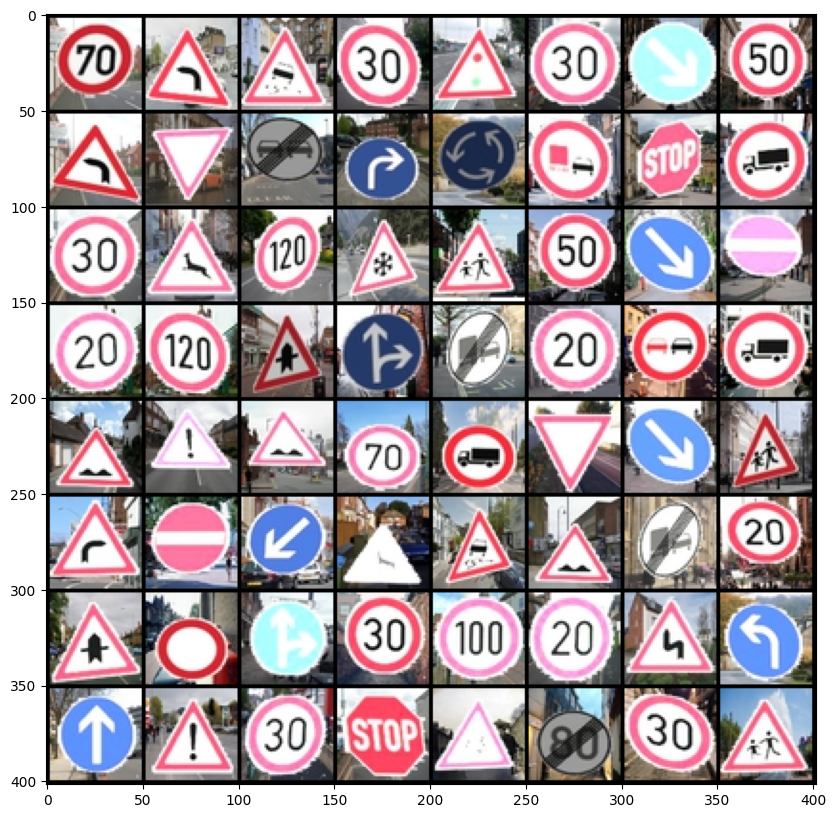

Target Dataset


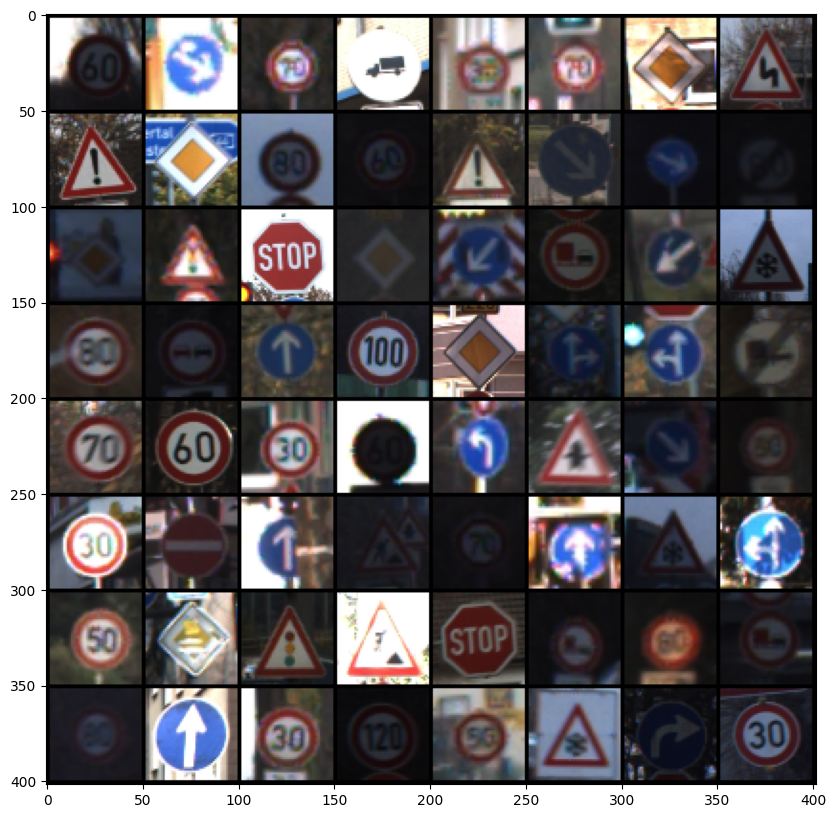

In [6]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random source training images
dataiter = iter(source_trainloader)
images, labels = dataiter.__next__()

# show images
print("Source Dataset")
imshow(torchvision.utils.make_grid(images))

# get some random target training images
dataiter = iter(target_trainloader)
images, labels = dataiter.__next__()

# show images
print("Target Dataset")
imshow(torchvision.utils.make_grid(images))

In [7]:
def plot_loss(losses, title):
    plt.plot(range(len(losses)), losses)
    plt.title(title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

In [8]:
def train(train_loaders, val_loaders, test_loader, model, optimizer, criteria, epochs = 25, model_save_path = "models/best_model.pt", scheduler = None):    
    train_losses = []
    train_source_label_losses = []
    train_source_domain_losses = []
    train_target_domain_losses = []
    val_losses = []
    val_source_label_losses = []
    val_target_label_losses = []
    min_val_loss = np.Inf
    
    lamda = 10
    lr0 = 0.01
    beta = 0.75

    model_save_dir = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        len_dataloader = min(len(train_loaders[0]), len(train_loaders[1]))
        pbar = tqdm(total = len_dataloader, position = 0, leave = True)
       
        train_loss = 0
        train_source_label_loss = 0
        train_source_domain_loss = 0
        train_target_domain_loss = 0
        val_loss = 0
        val_source_label_loss = 0
        val_target_label_loss = 0
    
        source_iter = iter(train_loaders[0])
        target_iter = iter(train_loaders[1])
#         for batch_idx, (data, target) in enumerate(train_loaders[0]):
        for batch_idx in range(len_dataloader):
            source_data, source_labels = source_iter.__next__()
            target_data, target_labels = target_iter.__next__()
            
            p = float(batch_idx + epoch * len_dataloader) / (epochs * len_dataloader)
            alpha = (2. / (1. + np.exp(-lamda * p))) - 1
            for g in optimizer.param_groups:
                g["lr"] = lr0 / np.power((1 + lamda * p), beta)
            
            source_domain_labels = torch.zeros(source_data.shape[0], device = device)
            target_domain_labels = torch.ones(target_data.shape[0], device = device)

            # if torch.cuda.is_available():
            #     # print("Using CUDA")
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data, target_labels = target_data.to(device), target_labels.to(device)
            
            optimizer.zero_grad()
            source_classes, source_domains = model(source_data, alpha)
            label_loss = criteria[0](source_classes, source_labels)
            source_domain_loss = criteria[1](source_domains[:, 0], source_domain_labels)
            
            target_classes, target_domains = model(target_data, alpha)
            target_domain_loss = criteria[1](target_domains[:, 0], target_domain_labels)
            
            loss = label_loss + source_domain_loss + target_domain_loss
            loss.backward()
            optimizer.step()

            train_source_label_loss += label_loss.cpu().data.item() * source_labels.shape[0]
            train_source_domain_loss += source_domain_loss.cpu().data.item() * source_domain_labels.shape[0]
            train_target_domain_loss += target_domain_loss.cpu().data.item() * target_domain_labels.shape[0]
            train_loss += loss.cpu().data.item()
            pbar.update(1)
            pbar.desc= f'Train Loss: {loss.item()}'
            
        train_loss /= len_dataloader
        train_source_label_loss /= len_dataloader
        train_source_domain_loss /= len_dataloader
        train_target_domain_loss /= len_dataloader
        train_losses.append(train_loss)
        train_source_label_losses.append(train_source_label_loss)
        train_source_domain_losses.append(train_source_domain_loss)
        train_target_domain_losses.append(train_target_domain_loss)
        
        if scheduler is not None:
            scheduler.step()     
            
#         if train_loss < min_val_loss:
#             min_val_loss = train_loss
#             torch.save(model.state_dict(), model_save_path)

        model.eval()
        with torch.no_grad():
            len_val_dataloader = min(len(val_loaders[0]), len(val_loaders[1]))
            source_val_iter = iter(val_loaders[0])
            target_val_iter = iter(val_loaders[1])
            
            for batch_ix in range(len_val_dataloader):
                source_val_data, source_val_labels = source_val_iter.__next__()
                target_val_data, target_val_labels = target_val_iter.__next__()
                
                # if torch.cuda.is_available():
                source_val_data, source_val_labels = source_val_data.to(device), source_val_labels.to(device)
                target_val_data, target_val_labels = target_val_data.to(device), target_val_labels.to(device)

                source_pred_labels, source_pred_domains = model(source_val_data, alpha)
                source_label_loss = criteria[0](source_pred_labels, source_val_labels)          
                target_pred_labels, target_pred_domains = model(target_val_data, alpha)
                target_label_loss = criteria[0](target_pred_labels, target_val_labels)
                
                loss = source_label_loss + target_label_loss
                val_source_label_loss += source_label_loss.cpu().data.item() * source_val_data.shape[0]
                val_target_label_loss += target_label_loss.cpu().data.item() * target_val_data.shape[0]
                val_loss += loss.cpu().data.item()
                # source_label_loss.cpu().data.item() * source_val_data.shape[0] + target_label_loss.cpu().data.item() * target_val_data.shape[0]
                
            val_loss /= len_val_dataloader
            val_source_label_loss /= len_val_dataloader
            val_target_label_loss /= len_val_dataloader
            val_losses.append(val_loss)
            val_source_label_losses.append(val_source_label_loss)
            val_target_label_losses.append(val_target_label_loss)

        if val_loss < min_val_loss:
            print("Saving at epoch %d" % (epoch))
            min_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            
        print("Epoch %d: Train Loss = %f, Val Loss = %f" % (epoch, train_loss, val_loss))
        pbar.refresh()
        pbar.close()

    model_save_path = model_save_path[:-3] + "_last.pt"
    torch.save(model.state_dict(), model_save_path)
    end_time = time.time()
    train_time = end_time - start_time
    
    plot_loss(train_losses, "Train Loss vs Epochs")
    plot_loss(train_source_label_losses, "Train Source Label Loss vs Epochs")
    plot_loss(train_source_domain_losses, "Train Source Domain Loss vs Epochs")
    plot_loss(train_target_domain_losses, "Train Target Domain Loss vs Epochs")
    plot_loss(val_losses, "Validation Loss vs Epochs")
    plot_loss(val_source_label_losses, "Validation Source Label Loss vs Epochs")
    plot_loss(val_target_label_losses, "Validation Target Label Loss vs Epochs")
    
#     start_time = time.time()
#     model.load_state_dict(torch.load(model_save_path))
#     get_model_size(model)
# #     train_report = evaluate(model, train_loader, criterion)
# #     test_report = evaluate(model, test_loader, criterion)
# #     end_time = time.time()
# #     eval_time = end_time - start_time
#     print("Training time = %f seconds" % (train_time))
# #     print("Evaluation time (on both, train and test sets) = %f seconds" % (eval_time))
            
# #     return train_report, test_report
    return None, None

Train Loss: 4.193965435028076: 100%|███████████████████████████████████████████████████▊| 396/397 [00:19<00:00, 19.09it/s]

Saving at epoch 0


Train Loss: 4.045588970184326: 100%|████████████████████████████████████████████████████| 397/397 [00:21<00:00, 18.65it/s]


Epoch 0: Train Loss = 4.804748, Val Loss = 5.168215


Train Loss: 2.783492088317871: 100%|████████████████████████████████████████████████████| 397/397 [00:15<00:00, 27.17it/s]

Saving at epoch 1


Train Loss: 3.8901009559631348: 100%|███████████████████████████████████████████████████| 397/397 [00:17<00:00, 22.83it/s]


Epoch 1: Train Loss = 3.462851, Val Loss = 3.315327


Train Loss: 2.8191978931427: 100%|█████████████████████████████████████████████████████▊| 396/397 [00:13<00:00, 33.23it/s]

Saving at epoch 2


Train Loss: 3.1532342433929443: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.15it/s]


Epoch 2: Train Loss = 3.150733, Val Loss = 2.974753


Train Loss: 2.9616775512695312: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.15it/s]


Epoch 3: Train Loss = 3.098702, Val Loss = 2.994573


Train Loss: 3.5311684608459473:  99%|██████████████████████████████████████████████████▍| 393/397 [00:13<00:00, 29.98it/s]

Saving at epoch 4


Train Loss: 2.7471024990081787: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.04it/s]


Epoch 4: Train Loss = 3.065593, Val Loss = 2.934956


Train Loss: 3.1791770458221436:  99%|██████████████████████████████████████████████████▍| 393/397 [00:11<00:00, 33.86it/s]

Saving at epoch 5


Train Loss: 3.303463935852051: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.40it/s]


Epoch 5: Train Loss = 3.063540, Val Loss = 2.714831


Train Loss: 3.410379409790039: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.55it/s]


Epoch 6: Train Loss = 3.053858, Val Loss = 2.869185


Train Loss: 2.932718276977539: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.11it/s]


Epoch 7: Train Loss = 3.053149, Val Loss = 2.806705


Train Loss: 2.592893600463867: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.31it/s]


Epoch 8: Train Loss = 3.042844, Val Loss = 2.806773


Train Loss: 3.0311577320098877: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.82it/s]


Epoch 9: Train Loss = 3.037961, Val Loss = 2.959526


Train Loss: 2.8262457847595215: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.24it/s]


Epoch 10: Train Loss = 3.056268, Val Loss = 2.867194


Train Loss: 3.0102148056030273: 100%|██████████████████████████████████████████████████▊| 396/397 [00:11<00:00, 35.59it/s]

Saving at epoch 11


Train Loss: 2.3799099922180176: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.41it/s]


Epoch 11: Train Loss = 3.053021, Val Loss = 2.533489


Train Loss: 2.5278878211975098: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.89it/s]


Epoch 12: Train Loss = 3.052989, Val Loss = 2.818532


Train Loss: 2.8509681224823: 100%|█████████████████████████████████████████████████████▊| 396/397 [00:11<00:00, 34.66it/s]

Saving at epoch 13


Train Loss: 2.9920623302459717: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.23it/s]


Epoch 13: Train Loss = 3.061805, Val Loss = 2.516202


Train Loss: 2.9534149169921875: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.90it/s]


Epoch 14: Train Loss = 3.099928, Val Loss = 3.522328


Train Loss: 2.9783852100372314: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.22it/s]


Epoch 15: Train Loss = 3.071235, Val Loss = 2.532578


Train Loss: 3.202087163925171: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.22it/s]


Epoch 16: Train Loss = 3.111836, Val Loss = 2.596162


Train Loss: 3.065121650695801: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.92it/s]


Epoch 17: Train Loss = 3.100629, Val Loss = 2.653321


Train Loss: 3.2439308166503906: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 26.90it/s]


Epoch 18: Train Loss = 3.101648, Val Loss = 2.645185


Train Loss: 3.2833762168884277:  99%|██████████████████████████████████████████████████▍| 393/397 [00:12<00:00, 34.09it/s]

Saving at epoch 19


Train Loss: 2.935142993927002: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.55it/s]


Epoch 19: Train Loss = 3.133433, Val Loss = 2.491337


Train Loss: 2.9205219745635986:  99%|██████████████████████████████████████████████████▍| 393/397 [00:11<00:00, 32.44it/s]

Saving at epoch 20


Train Loss: 3.3196606636047363: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.25it/s]


Epoch 20: Train Loss = 3.111952, Val Loss = 2.418917


Train Loss: 3.1050796508789062: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.65it/s]


Epoch 21: Train Loss = 3.155967, Val Loss = 2.506860


Train Loss: 2.8746047019958496: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.01it/s]


Epoch 22: Train Loss = 3.163890, Val Loss = 2.642049


Train Loss: 2.930511713027954: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.83it/s]


Epoch 23: Train Loss = 3.157379, Val Loss = 2.828545


Train Loss: 3.122591495513916:  99%|███████████████████████████████████████████████████▌| 394/397 [00:11<00:00, 34.63it/s]

Saving at epoch 24


Train Loss: 3.5236825942993164: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 30.77it/s]


Epoch 24: Train Loss = 3.143284, Val Loss = 2.117509


Train Loss: 2.9891560077667236:  99%|██████████████████████████████████████████████████▌| 394/397 [00:11<00:00, 34.34it/s]

Saving at epoch 25


Train Loss: 3.339655876159668: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.17it/s]


Epoch 25: Train Loss = 3.175529, Val Loss = 2.062428


Train Loss: 2.628994941711426: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.31it/s]


Epoch 26: Train Loss = 3.164608, Val Loss = 2.263798


Train Loss: 3.234262466430664: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.91it/s]


Epoch 27: Train Loss = 3.182182, Val Loss = 2.270135


Train Loss: 3.459322929382324: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.00it/s]


Epoch 28: Train Loss = 3.181203, Val Loss = 2.361737


Train Loss: 2.8643834590911865: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.25it/s]


Epoch 29: Train Loss = 3.173551, Val Loss = 2.064078


Train Loss: 3.408550500869751: 100%|███████████████████████████████████████████████████▊| 396/397 [00:11<00:00, 36.10it/s]

Saving at epoch 30


Train Loss: 3.7578864097595215: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.54it/s]


Epoch 30: Train Loss = 3.185504, Val Loss = 1.980715


Train Loss: 2.6612114906311035:  99%|██████████████████████████████████████████████████▍| 393/397 [00:11<00:00, 35.79it/s]

Saving at epoch 31


Train Loss: 3.1278724670410156: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.21it/s]


Epoch 31: Train Loss = 3.204459, Val Loss = 1.975051


Train Loss: 3.0104382038116455: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.67it/s]


Epoch 32: Train Loss = 3.195215, Val Loss = 2.224809


Train Loss: 3.301403522491455:  99%|███████████████████████████████████████████████████▍| 393/397 [00:11<00:00, 33.28it/s]

Saving at epoch 33


Train Loss: 3.063472032546997: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.91it/s]


Epoch 33: Train Loss = 3.207365, Val Loss = 1.870508


Train Loss: 2.849167585372925: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.43it/s]


Epoch 34: Train Loss = 3.223341, Val Loss = 2.042539


Train Loss: 3.0223641395568848: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.13it/s]


Epoch 35: Train Loss = 3.197510, Val Loss = 2.044683


Train Loss: 3.3087782859802246:  99%|██████████████████████████████████████████████████▍| 393/397 [00:11<00:00, 34.40it/s]

Saving at epoch 36


Train Loss: 3.667308807373047: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.41it/s]


Epoch 36: Train Loss = 3.200459, Val Loss = 1.790311


Train Loss: 3.1800668239593506: 100%|██████████████████████████████████████████████████▊| 396/397 [00:11<00:00, 35.02it/s]

Saving at epoch 37


Train Loss: 3.2481932640075684: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.50it/s]


Epoch 37: Train Loss = 3.203516, Val Loss = 1.737725


Train Loss: 3.2014453411102295: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.77it/s]


Epoch 38: Train Loss = 3.216879, Val Loss = 1.958353


Train Loss: 3.5479202270507812: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.21it/s]


Epoch 39: Train Loss = 3.237354, Val Loss = 1.971957


Train Loss: 3.3315367698669434: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.44it/s]


Epoch 40: Train Loss = 3.236091, Val Loss = 1.853989


Train Loss: 3.2950820922851562: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.18it/s]


Epoch 41: Train Loss = 3.230567, Val Loss = 1.991280


Train Loss: 2.9588680267333984: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.69it/s]


Epoch 42: Train Loss = 3.218012, Val Loss = 1.944998


Train Loss: 3.3985955715179443: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 32.12it/s]


Epoch 43: Train Loss = 3.215363, Val Loss = 1.840972


Train Loss: 3.304133892059326:  99%|███████████████████████████████████████████████████▋| 395/397 [00:17<00:00, 16.63it/s]

Saving at epoch 44


Train Loss: 3.304600477218628: 100%|████████████████████████████████████████████████████| 397/397 [00:18<00:00, 21.27it/s]


Epoch 44: Train Loss = 3.229888, Val Loss = 1.718705


Train Loss: 2.961535930633545:  99%|███████████████████████████████████████████████████▋| 395/397 [00:11<00:00, 37.84it/s]

Saving at epoch 45


Train Loss: 3.687143325805664: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.44it/s]


Epoch 45: Train Loss = 3.213605, Val Loss = 1.694746


Train Loss: 3.5142369270324707: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.70it/s]


Epoch 46: Train Loss = 3.206556, Val Loss = 1.891074


Train Loss: 3.615941286087036:  99%|███████████████████████████████████████████████████▍| 393/397 [00:13<00:00, 33.49it/s]

Saving at epoch 47


Train Loss: 3.7558939456939697: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.03it/s]


Epoch 47: Train Loss = 3.230455, Val Loss = 1.657873


Train Loss: 3.355698823928833: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.35it/s]


Epoch 48: Train Loss = 3.214696, Val Loss = 1.702555


Train Loss: 3.263354778289795: 100%|████████████████████████████████████████████████████| 397/397 [00:20<00:00, 18.91it/s]


Epoch 49: Train Loss = 3.216159, Val Loss = 1.812703


Train Loss: 3.3637290000915527: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 30.60it/s]


Epoch 50: Train Loss = 3.254105, Val Loss = 1.846459


Train Loss: 3.34486985206604:  99%|████████████████████████████████████████████████████▍| 393/397 [00:11<00:00, 35.85it/s]

Saving at epoch 51


Train Loss: 3.2051219940185547: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.43it/s]


Epoch 51: Train Loss = 3.225198, Val Loss = 1.554612


Train Loss: 3.022151231765747: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 26.70it/s]


Epoch 52: Train Loss = 3.219747, Val Loss = 1.625840


Train Loss: 2.898000955581665: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.30it/s]


Epoch 53: Train Loss = 3.258109, Val Loss = 1.639610


Train Loss: 3.220252275466919: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.36it/s]


Epoch 54: Train Loss = 3.240876, Val Loss = 1.810930


Train Loss: 2.998621940612793: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.31it/s]


Epoch 55: Train Loss = 3.229202, Val Loss = 1.601374


Train Loss: 3.7340550422668457: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.10it/s]


Epoch 56: Train Loss = 3.249789, Val Loss = 1.598614


Train Loss: 3.1654980182647705: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.81it/s]


Epoch 57: Train Loss = 3.227471, Val Loss = 1.636470


Train Loss: 3.238450050354004:  99%|███████████████████████████████████████████████████▍| 393/397 [00:12<00:00, 35.18it/s]

Saving at epoch 58


Train Loss: 3.443463087081909: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.92it/s]


Epoch 58: Train Loss = 3.223244, Val Loss = 1.519525


Train Loss: 3.660393238067627: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.18it/s]


Epoch 59: Train Loss = 3.260580, Val Loss = 1.768655


Train Loss: 3.3109803199768066: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.12it/s]


Epoch 60: Train Loss = 3.232827, Val Loss = 1.673193


Train Loss: 3.552086353302002: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.01it/s]


Epoch 61: Train Loss = 3.248325, Val Loss = 1.789683


Train Loss: 3.211254596710205: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.44it/s]


Epoch 62: Train Loss = 3.242737, Val Loss = 1.565737


Train Loss: 3.336385488510132: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.49it/s]


Epoch 63: Train Loss = 3.234811, Val Loss = 1.594566


Train Loss: 2.797349691390991: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 30.68it/s]


Epoch 64: Train Loss = 3.229952, Val Loss = 1.714478


Train Loss: 3.2522664070129395: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.59it/s]


Epoch 65: Train Loss = 3.233328, Val Loss = 1.556907


Train Loss: 2.964733600616455: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.27it/s]


Epoch 66: Train Loss = 3.240841, Val Loss = 1.740197


Train Loss: 3.5599465370178223:  99%|██████████████████████████████████████████████████▍| 393/397 [00:12<00:00, 32.85it/s]

Saving at epoch 67


Train Loss: 3.0902669429779053: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.85it/s]


Epoch 67: Train Loss = 3.212928, Val Loss = 1.471965


Train Loss: 3.0989418029785156: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 30.92it/s]


Epoch 68: Train Loss = 3.244322, Val Loss = 1.584986


Train Loss: 3.3772714138031006: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.95it/s]


Epoch 69: Train Loss = 3.222631, Val Loss = 1.577240


Train Loss: 2.9711148738861084: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.88it/s]


Epoch 70: Train Loss = 3.231793, Val Loss = 1.501734


Train Loss: 3.1938178539276123: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.47it/s]


Epoch 71: Train Loss = 3.245616, Val Loss = 1.604045


Train Loss: 3.6886606216430664: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.49it/s]


Epoch 72: Train Loss = 3.240320, Val Loss = 1.501049


Train Loss: 3.3474373817443848: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 30.58it/s]


Epoch 73: Train Loss = 3.237715, Val Loss = 1.503559


Train Loss: 2.958735704421997: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.98it/s]


Epoch 74: Train Loss = 3.222367, Val Loss = 1.579408


Train Loss: 3.3119945526123047: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.48it/s]


Epoch 75: Train Loss = 3.252305, Val Loss = 1.501007


Train Loss: 3.0064492225646973: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.25it/s]


Epoch 76: Train Loss = 3.209322, Val Loss = 1.610511


Train Loss: 3.333160638809204:  99%|███████████████████████████████████████████████████▍| 393/397 [00:11<00:00, 33.89it/s]

Saving at epoch 77


Train Loss: 2.5240278244018555: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.41it/s]


Epoch 77: Train Loss = 3.237300, Val Loss = 1.428710


Train Loss: 3.4461722373962402: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.36it/s]


Epoch 78: Train Loss = 3.213201, Val Loss = 1.532357


Train Loss: 3.54669189453125: 100%|█████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.45it/s]


Epoch 79: Train Loss = 3.237314, Val Loss = 1.503791


Train Loss: 3.214175224304199:  99%|███████████████████████████████████████████████████▋| 395/397 [00:12<00:00, 33.39it/s]

Saving at epoch 80


Train Loss: 2.9452624320983887: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.20it/s]


Epoch 80: Train Loss = 3.236487, Val Loss = 1.424446


Train Loss: 3.3475399017333984: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.29it/s]


Epoch 81: Train Loss = 3.266151, Val Loss = 1.520636


Train Loss: 3.002742290496826: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.78it/s]


Epoch 82: Train Loss = 3.221548, Val Loss = 1.451128


Train Loss: 3.2454378604888916: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 30.23it/s]


Epoch 83: Train Loss = 3.243439, Val Loss = 1.488586


Train Loss: 3.4861040115356445: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.19it/s]


Epoch 84: Train Loss = 3.222496, Val Loss = 1.615162


Train Loss: 3.4263241291046143: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.60it/s]


Epoch 85: Train Loss = 3.228266, Val Loss = 1.444611


Train Loss: 3.196624994277954: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 30.90it/s]


Epoch 86: Train Loss = 3.240657, Val Loss = 1.542331


Train Loss: 3.250302791595459: 100%|████████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.09it/s]


Epoch 87: Train Loss = 3.232816, Val Loss = 1.500711


Train Loss: 3.343947410583496: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.73it/s]


Epoch 88: Train Loss = 3.234518, Val Loss = 1.455239


Train Loss: 3.5070738792419434:  99%|██████████████████████████████████████████████████▋| 395/397 [00:12<00:00, 33.05it/s]

Saving at epoch 89


Train Loss: 3.1686244010925293: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.34it/s]


Epoch 89: Train Loss = 3.236720, Val Loss = 1.362915


Train Loss: 3.149509906768799: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.77it/s]


Epoch 90: Train Loss = 3.222198, Val Loss = 1.468863


Train Loss: 3.4353654384613037: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 30.60it/s]


Epoch 91: Train Loss = 3.251935, Val Loss = 1.456984


Train Loss: 2.9173476696014404: 100%|███████████████████████████████████████████████████| 397/397 [00:12<00:00, 31.31it/s]


Epoch 92: Train Loss = 3.239206, Val Loss = 1.492511


Train Loss: 3.2947921752929688: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.51it/s]


Epoch 93: Train Loss = 3.231785, Val Loss = 1.413614


Train Loss: 3.347381353378296: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.71it/s]


Epoch 94: Train Loss = 3.229463, Val Loss = 1.468240


Train Loss: 3.144092082977295: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.62it/s]


Epoch 95: Train Loss = 3.232720, Val Loss = 1.363741


Train Loss: 3.353214740753174:  99%|███████████████████████████████████████████████████▍| 393/397 [00:11<00:00, 31.92it/s]

Saving at epoch 96


Train Loss: 3.3118340969085693: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.35it/s]


Epoch 96: Train Loss = 3.231671, Val Loss = 1.340663


Train Loss: 3.2568440437316895: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.61it/s]


Epoch 97: Train Loss = 3.259216, Val Loss = 1.509254


Train Loss: 3.2101099491119385: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.22it/s]


Epoch 98: Train Loss = 3.258847, Val Loss = 1.445470


Train Loss: 3.3944592475891113: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.23it/s]

Epoch 99: Train Loss = 3.252534, Val Loss = 1.528255


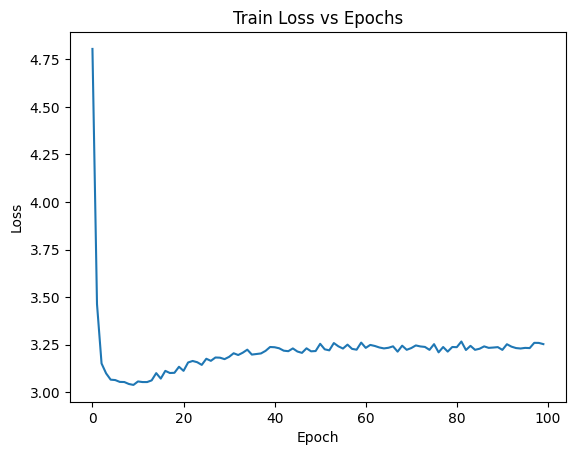

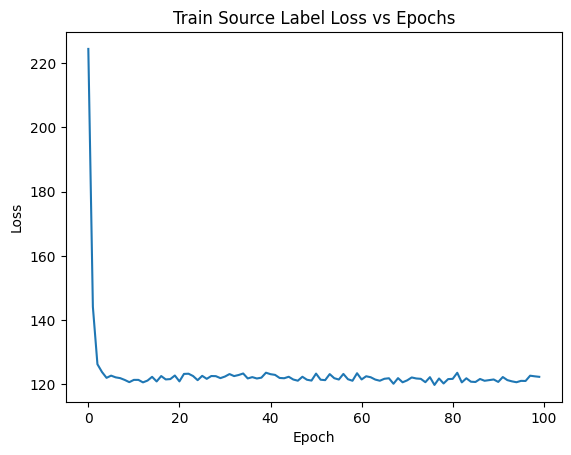

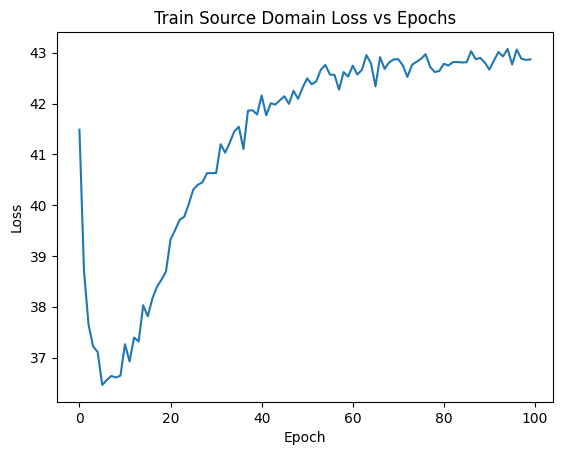

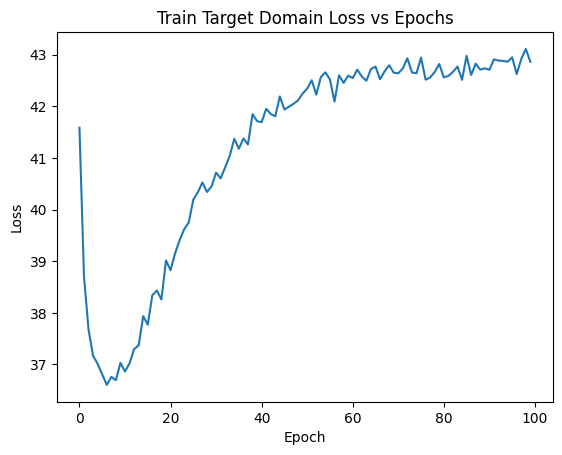

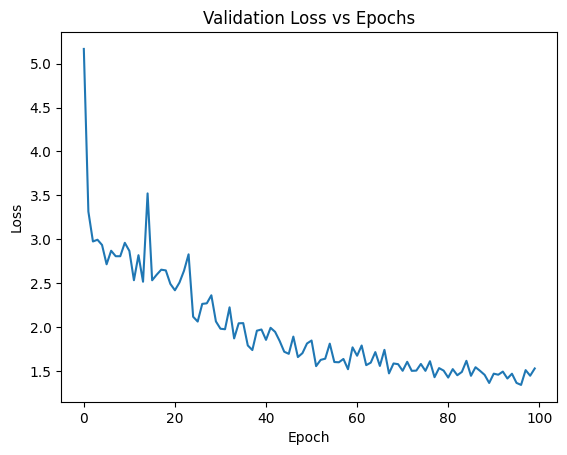

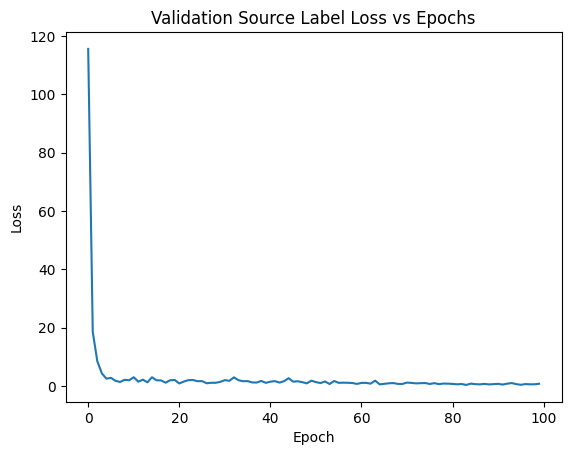

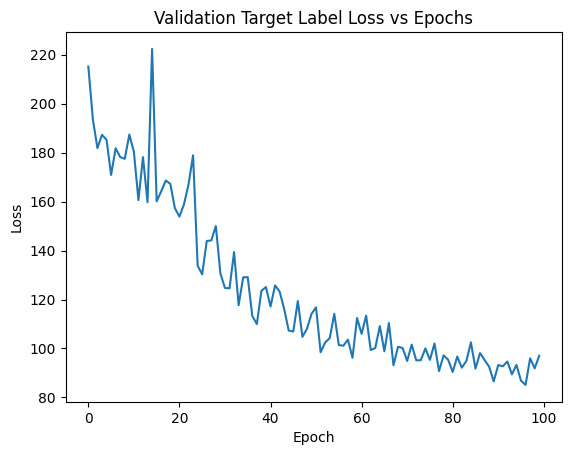

In [21]:
lr = 0.01
model = GTSRB_CNN(True).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# criteria = [nn.NLLLoss(), nn.BCELoss()]
criteria = [nn.CrossEntropyLoss(), nn.BCELoss()]
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train([source_trainloader, target_trainloader], [source_valloader, target_valloader], 
                                  target_testloader, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt", scheduler)

In [9]:
def evaluate(model, target_valloader, domain_adaptation = True, alpha = 1.):
    preds_labels = []
    preds_domains = []
    gt_labels = []
    model = model.cpu()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(target_valloader):
            # data.to(device)
            # target.to(device)

            if domain_adaptation:
                pred_labels, pred_domains = model(data, alpha)
                pred_domains = np.round(np.array(pred_domains))
                preds_domains.append(pred_domains)
            
            else:
                pred_labels = model(data, alpha)
                
            # pred_labels = np.argmax(np.exp(np.array(pred_labels)), axis = 1)
            softmax = torch.nn.Softmax()
            pred_labels = np.argmax(np.array(softmax(pred_labels)), axis = 1)
            
            preds_labels.append(pred_labels)
            gt_labels.append(np.array(target))

    preds_labels = np.array(preds_labels).reshape(-1)
    gt_labels = np.array(gt_labels).reshape(-1)    
    print("Class Label Report")
    print(classification_report(preds_labels, gt_labels))
    
    if domain_adaptation:
        preds_domains = np.array(preds_domains).reshape(-1)
        gt_domains = np.ones(gt_labels.shape)
        print("Domain Label Report")
        print(classification_report(preds_domains, gt_domains))

In [50]:
model_best = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt"
model_best.load_state_dict(torch.load(model_save_path))
model_best.eval()
evaluate(model_best, target_valloader, True, 0.)

Class Label Report
              precision    recall  f1-score   support

           0       0.86      0.12      0.21        50
           1       0.65      0.58      0.61        81
           2       0.54      0.80      0.65        54
           3       0.51      0.90      0.65        29
           4       0.38      0.72      0.50        36
           5       0.38      0.62      0.47        42
           6       0.46      0.30      0.36        20
           7       0.50      0.49      0.49        43
           8       0.19      0.41      0.26        17
           9       0.84      0.91      0.87        46
          10       0.78      0.89      0.83        45
          11       0.73      0.83      0.78        36
          12       0.82      0.85      0.83        62
          13       0.84      0.99      0.91        69
          14       0.97      0.78      0.86        36
          15       0.95      0.57      0.71        35
          16       0.85      0.57      0.68        30
        

### Source Only Model

In [10]:
def train(train_loader, val_loader, test_loader, model, optimizer, criterion, epochs = 25, model_save_path = "models/best_model.pt", scheduler = None):
    train_losses = []
    val_losses = []
    min_val_loss = np.Inf

    model_save_dir = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        pbar = tqdm(total = len(train_loader), position = 0, leave = True)
        train_loss = 0
        val_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            out = model(data, 1.)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.cpu().data.item() * data.size(0)
            pbar.update(1)
            pbar.desc= f'Train Loss: {loss.item()}'

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        if scheduler is not None:
            scheduler.step()
            
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                
                out = model(data, 1.)
                loss = criterion(out, target)
                val_loss += loss.cpu().data.item() * data.size(0)
                
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            
        print("Epoch %d: Train Loss = %f, Val Loss = %f" % (epoch, train_loss, val_loss))
        pbar.refresh()
        pbar.close()

    end_time = time.time()
    train_time = end_time - start_time
    
    plot_loss(train_losses, "Train Loss vs Epochs")
    plot_loss(val_losses, "Validation Loss vs Epochs")
    
#     start_time = time.time()
#     model.load_state_dict(torch.load(model_save_path))
#     get_model_size(model)
# #     train_report = evaluate(model, train_loader, criterion)
# #     test_report = evaluate(model, test_loader, criterion)
# #     end_time = time.time()
# #     eval_time = end_time - start_time
#     print("Training time = %f seconds" % (train_time))
# #     print("Evaluation time (on both, train and test sets) = %f seconds" % (eval_time))
            
# #     return train_report, test_report
    return None, None

Train Loss: 1.6450610160827637: 100%|█████████████████████████████████████████████████| 1563/1563 [07:02<00:00,  3.70it/s]


Epoch 0: Train Loss = 157.805893, Val Loss = 4.880070


Train Loss: 1.0509703159332275: 100%|█████████████████████████████████████████████████| 1563/1563 [01:42<00:00, 15.24it/s]


Epoch 1: Train Loss = 121.848771, Val Loss = 1.352504


Train Loss: 1.7655713558197021: 100%|█████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.63it/s]


Epoch 2: Train Loss = 120.740176, Val Loss = 0.775498


Train Loss: 2.217122793197632: 100%|██████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.58it/s]


Epoch 3: Train Loss = 120.385501, Val Loss = 0.768713


Train Loss: 2.4377644062042236: 100%|█████████████████████████████████████████████████| 1563/1563 [01:05<00:00, 23.87it/s]


Epoch 4: Train Loss = 120.180665, Val Loss = 0.505921


Train Loss: 2.2327771186828613: 100%|█████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.63it/s]


Epoch 5: Train Loss = 120.527851, Val Loss = 0.308827


Train Loss: 0.9298346042633057: 100%|█████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.05it/s]


Epoch 6: Train Loss = 120.539682, Val Loss = 0.296625


Train Loss: 2.2281060218811035: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.77it/s]


Epoch 7: Train Loss = 120.516638, Val Loss = 0.369989


Train Loss: 1.965049386024475: 100%|██████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.11it/s]


Epoch 8: Train Loss = 121.001383, Val Loss = 0.302105


Train Loss: 2.088113784790039: 100%|██████████████████████████████████████████████████| 1563/1563 [00:58<00:00, 26.68it/s]


Epoch 9: Train Loss = 119.867993, Val Loss = 0.231541


Train Loss: 1.6269762516021729: 100%|█████████████████████████████████████████████████| 1563/1563 [00:57<00:00, 27.00it/s]


Epoch 10: Train Loss = 120.310877, Val Loss = 0.212875


Train Loss: 1.9842363595962524: 100%|█████████████████████████████████████████████████| 1563/1563 [00:58<00:00, 26.62it/s]


Epoch 11: Train Loss = 120.275189, Val Loss = 0.199646


Train Loss: 2.0125792026519775: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.09it/s]


Epoch 12: Train Loss = 120.445136, Val Loss = 0.281950


Train Loss: 2.1651792526245117: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.74it/s]


Epoch 13: Train Loss = 120.404000, Val Loss = 0.186005


Train Loss: 2.2362120151519775: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.94it/s]


Epoch 14: Train Loss = 120.105171, Val Loss = 0.174975


Train Loss: 1.7428362369537354: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.24it/s]


Epoch 15: Train Loss = 119.742518, Val Loss = 0.107002


Train Loss: 1.9970723390579224: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]


Epoch 16: Train Loss = 119.538554, Val Loss = 0.110498


Train Loss: 1.8696832656860352: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.68it/s]


Epoch 17: Train Loss = 120.666816, Val Loss = 0.136809


Train Loss: 1.972201943397522: 100%|██████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.60it/s]


Epoch 18: Train Loss = 119.796170, Val Loss = 0.282377


Train Loss: 1.9840883016586304: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.92it/s]


Epoch 19: Train Loss = 120.272259, Val Loss = 0.165484


Train Loss: 2.0818557739257812: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.54it/s]


Epoch 20: Train Loss = 119.899923, Val Loss = 0.078182


Train Loss: 1.6357612609863281: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.78it/s]


Epoch 21: Train Loss = 119.766897, Val Loss = 0.169596


Train Loss: 1.8935258388519287: 100%|█████████████████████████████████████████████████| 1563/1563 [00:58<00:00, 26.73it/s]


Epoch 22: Train Loss = 119.716177, Val Loss = 0.087443


Train Loss: 1.5246087312698364: 100%|█████████████████████████████████████████████████| 1563/1563 [00:58<00:00, 26.62it/s]


Epoch 23: Train Loss = 119.777279, Val Loss = 0.075341


Train Loss: 2.1229240894317627: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.49it/s]


Epoch 24: Train Loss = 119.925635, Val Loss = 0.090711


Train Loss: 1.6201093196868896: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.87it/s]


Epoch 25: Train Loss = 120.310131, Val Loss = 0.089919


Train Loss: 1.7469782829284668: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.09it/s]


Epoch 26: Train Loss = 120.409959, Val Loss = 0.099612


Train Loss: 1.312965989112854: 100%|██████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.80it/s]


Epoch 27: Train Loss = 120.600162, Val Loss = 0.090697


Train Loss: 1.4153242111206055: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.73it/s]


Epoch 28: Train Loss = 119.519624, Val Loss = 0.138544


Train Loss: 2.344156503677368: 100%|██████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.01it/s]


Epoch 29: Train Loss = 119.540439, Val Loss = 0.085786


Train Loss: 1.7399377822875977: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.62it/s]


Epoch 30: Train Loss = 120.275348, Val Loss = 0.072027


Train Loss: 1.4133507013320923: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.79it/s]


Epoch 31: Train Loss = 119.784059, Val Loss = 0.127263


Train Loss: 2.02901029586792: 100%|███████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.30it/s]


Epoch 32: Train Loss = 120.215715, Val Loss = 0.107060


Train Loss: 2.003859758377075: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.52it/s]


Epoch 33: Train Loss = 120.385514, Val Loss = 0.129902


Train Loss: 1.9848109483718872: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.60it/s]


Epoch 34: Train Loss = 119.901560, Val Loss = 0.063945


Train Loss: 1.98564875125885: 100%|███████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.72it/s]


Epoch 35: Train Loss = 120.482824, Val Loss = 0.051196


Train Loss: 1.8580474853515625: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.71it/s]


Epoch 36: Train Loss = 120.153031, Val Loss = 0.046100


Train Loss: 2.2049362659454346: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.73it/s]


Epoch 37: Train Loss = 120.332543, Val Loss = 0.109675


Train Loss: 2.232146739959717: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.96it/s]


Epoch 38: Train Loss = 119.300031, Val Loss = 0.130497


Train Loss: 2.0953125953674316: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.22it/s]


Epoch 39: Train Loss = 119.559535, Val Loss = 0.057858


Train Loss: 1.6201306581497192: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.37it/s]


Epoch 40: Train Loss = 120.354489, Val Loss = 0.173321


Train Loss: 1.276322603225708: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.76it/s]


Epoch 41: Train Loss = 119.949683, Val Loss = 0.066133


Train Loss: 2.320897102355957: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.38it/s]


Epoch 42: Train Loss = 120.395053, Val Loss = 0.118546


Train Loss: 1.6151769161224365: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.22it/s]


Epoch 43: Train Loss = 120.060897, Val Loss = 0.063298


Train Loss: 1.5454317331314087: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.66it/s]


Epoch 44: Train Loss = 120.123362, Val Loss = 0.432774


Train Loss: 2.1799020767211914: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.76it/s]


Epoch 45: Train Loss = 120.866078, Val Loss = 0.127094


Train Loss: 1.8685663938522339: 100%|█████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]


Epoch 46: Train Loss = 119.906736, Val Loss = 0.101377


Train Loss: 1.4062103033065796: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.74it/s]


Epoch 47: Train Loss = 120.370370, Val Loss = 0.124176


Train Loss: 2.24334979057312: 100%|███████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.37it/s]


Epoch 48: Train Loss = 120.612130, Val Loss = 0.145863


Train Loss: 2.4344606399536133: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.68it/s]


Epoch 49: Train Loss = 120.721351, Val Loss = 0.170541


Train Loss: 2.01912784576416: 100%|███████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.88it/s]


Epoch 50: Train Loss = 120.192869, Val Loss = 0.102160


Train Loss: 2.2296223640441895: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 26.01it/s]


Epoch 51: Train Loss = 120.745100, Val Loss = 0.105361


Train Loss: 1.429404377937317: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.98it/s]


Epoch 52: Train Loss = 120.465849, Val Loss = 0.065928


Train Loss: 1.636182427406311: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.75it/s]


Epoch 53: Train Loss = 121.968667, Val Loss = 0.242665


Train Loss: 1.9961531162261963: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.38it/s]


Epoch 54: Train Loss = 120.363602, Val Loss = 0.291331


Train Loss: 1.7460349798202515: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.03it/s]


Epoch 55: Train Loss = 120.626358, Val Loss = 0.158098


Train Loss: 1.7508713006973267: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.11it/s]


Epoch 56: Train Loss = 120.267619, Val Loss = 0.222604


Train Loss: 2.251678466796875: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.25it/s]


Epoch 57: Train Loss = 120.573033, Val Loss = 0.626894


Train Loss: 1.8838880062103271: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.20it/s]


Epoch 58: Train Loss = 121.088988, Val Loss = 0.230618


Train Loss: 2.658454656600952: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.46it/s]


Epoch 59: Train Loss = 122.290250, Val Loss = 0.825166


Train Loss: 2.1057863235473633: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.27it/s]


Epoch 60: Train Loss = 122.273119, Val Loss = 0.261243


Train Loss: 1.8537296056747437: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.52it/s]


Epoch 61: Train Loss = 122.011869, Val Loss = 0.992752


Train Loss: 2.020129680633545: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.45it/s]


Epoch 62: Train Loss = 123.287674, Val Loss = 3.006255


Train Loss: 1.633140206336975: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.76it/s]


Epoch 63: Train Loss = 127.914694, Val Loss = 1.133484


Train Loss: 1.8969560861587524: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.58it/s]


Epoch 64: Train Loss = 129.366517, Val Loss = 3.349356


Train Loss: 1.0386414527893066: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.59it/s]


Epoch 65: Train Loss = 130.853060, Val Loss = 2.530044


Train Loss: 1.9853802919387817: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.52it/s]


Epoch 66: Train Loss = 137.369041, Val Loss = 4.499804


Train Loss: 3.33939790725708: 100%|███████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.64it/s]


Epoch 67: Train Loss = 148.303293, Val Loss = 9.704487


Train Loss: 2.574509859085083: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.29it/s]


Epoch 68: Train Loss = 154.279440, Val Loss = 13.417350


Train Loss: 1.7300444841384888: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.68it/s]


Epoch 69: Train Loss = 151.966100, Val Loss = 14.750207


Train Loss: 2.03098726272583: 100%|███████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.42it/s]


Epoch 70: Train Loss = 150.249041, Val Loss = 20.370130


Train Loss: 2.3244447708129883: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.83it/s]


Epoch 71: Train Loss = 151.812384, Val Loss = 20.690099


Train Loss: 2.940875291824341: 100%|██████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.02it/s]


Epoch 72: Train Loss = 165.077114, Val Loss = 24.610512


Train Loss: 3.0071017742156982: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.33it/s]


Epoch 73: Train Loss = 183.383166, Val Loss = 31.418875


Train Loss: 1.8168002367019653: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.83it/s]


Epoch 74: Train Loss = 176.563533, Val Loss = 29.553812


Train Loss: 2.5152125358581543: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.16it/s]


Epoch 75: Train Loss = 192.511322, Val Loss = 28.880878


Train Loss: 2.290900468826294: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.48it/s]


Epoch 76: Train Loss = 205.907519, Val Loss = 60.842729


Train Loss: 3.44815731048584: 100%|███████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.57it/s]


Epoch 77: Train Loss = 212.245815, Val Loss = 129.908792


Train Loss: 3.2622060775756836: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.69it/s]


Epoch 78: Train Loss = 216.568081, Val Loss = 239.626398


Train Loss: 3.487821340560913: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.76it/s]


Epoch 79: Train Loss = 234.749539, Val Loss = 239.537159


Train Loss: 3.7145609855651855: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.72it/s]


Epoch 80: Train Loss = 242.294593, Val Loss = 239.523959


Train Loss: 3.727832078933716: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.63it/s]


Epoch 81: Train Loss = 239.888077, Val Loss = 239.505037


Train Loss: 3.7060537338256836: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.46it/s]


Epoch 82: Train Loss = 240.170453, Val Loss = 239.494458


Train Loss: 3.741177797317505: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.51it/s]


Epoch 83: Train Loss = 239.657014, Val Loss = 239.487162


Train Loss: 3.759988307952881: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.37it/s]


Epoch 84: Train Loss = 239.724761, Val Loss = 239.477168


Train Loss: 3.7292227745056152: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.07it/s]


Epoch 85: Train Loss = 239.775214, Val Loss = 239.498394


Train Loss: 3.7546799182891846: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.31it/s]


Epoch 86: Train Loss = 239.444087, Val Loss = 239.494116


Train Loss: 3.744556427001953: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.32it/s]


Epoch 87: Train Loss = 239.991582, Val Loss = 239.493523


Train Loss: 3.799135684967041: 100%|██████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.83it/s]


Epoch 88: Train Loss = 240.604147, Val Loss = 239.505396


Train Loss: 3.7867114543914795: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.85it/s]


Epoch 89: Train Loss = 239.965988, Val Loss = 239.502504


Train Loss: 3.751101493835449: 100%|██████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.78it/s]


Epoch 90: Train Loss = 239.703284, Val Loss = 239.494706


Train Loss: 3.761291742324829: 100%|██████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.11it/s]


Epoch 91: Train Loss = 239.670081, Val Loss = 239.516650


Train Loss: 3.775815963745117: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.54it/s]


Epoch 92: Train Loss = 239.650207, Val Loss = 239.520143


Train Loss: 3.7823479175567627: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.85it/s]


Epoch 93: Train Loss = 239.669101, Val Loss = 239.516360


Train Loss: 3.7614502906799316: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.18it/s]


Epoch 94: Train Loss = 239.640174, Val Loss = 239.502641


Train Loss: 3.631061315536499: 100%|██████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.39it/s]


Epoch 95: Train Loss = 239.784682, Val Loss = 239.503596


Train Loss: 3.7984299659729004: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.84it/s]


Epoch 96: Train Loss = 240.053702, Val Loss = 239.512916


Train Loss: 3.7364609241485596: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.48it/s]


Epoch 97: Train Loss = 240.451830, Val Loss = 239.522381


Train Loss: 3.7527105808258057: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.03it/s]


Epoch 98: Train Loss = 240.180794, Val Loss = 239.499179


Train Loss: 3.764054298400879: 100%|██████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.71it/s]

Epoch 99: Train Loss = 239.599783, Val Loss = 239.486895


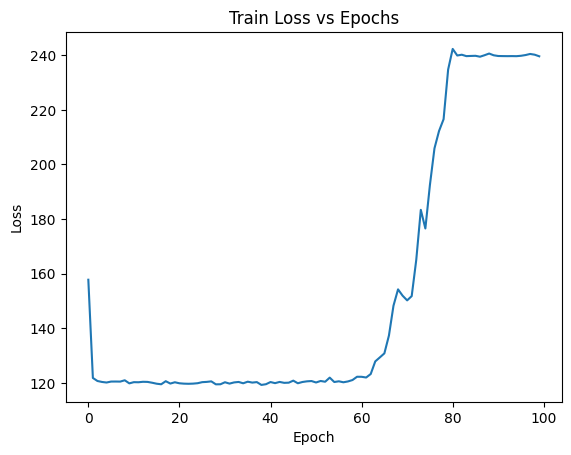

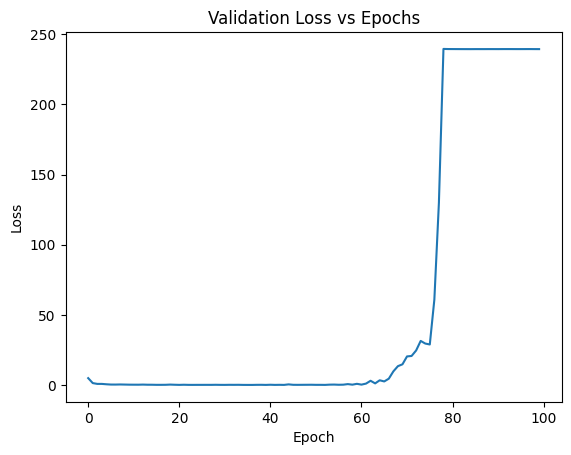

In [13]:
lr = 0.01
source_only_model = GTSRB_CNN(False).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(source_only_model.parameters(), lr = lr, momentum = 0.9)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train(source_trainloader, source_valloader, 
                                  target_testloader, source_only_model, optimizer, criterion, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_source_only.pt", scheduler)

In [14]:
model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_source_only.pt"
model.load_state_dict(torch.load(model_save_path))
model.eval()
evaluate(model, target_valloader, False)

Class Label Report
              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.44      1.00      0.61        33
           2       0.24      0.86      0.37        22
           3       0.19      0.90      0.32        10
           4       0.27      0.94      0.42        18
           5       0.03      1.00      0.05         2
           6       0.25      0.60      0.35         5
           7       0.24      0.62      0.35        13
           8       0.03      0.25      0.06         4
           9       0.38      0.89      0.53        18
          10       0.24      0.53      0.33        36
          11       0.31      0.87      0.46        15
          12       0.79      0.79      0.79        70
          13       0.58      0.77      0.66        48
          14       1.00      0.47      0.63        43
          15       0.42      0.19      0.26        26
          16       0.82      0.31      0.45        29
        

### Target Only Model

Train Loss: 3.24573016166687: 100%|█████████████████████████████████████████████████████| 397/397 [00:50<00:00,  7.87it/s]


Epoch 0: Train Loss = 224.855204, Val Loss = 185.157062


Train Loss: 2.104954481124878: 100%|████████████████████████████████████████████████████| 397/397 [00:18<00:00, 21.42it/s]


Epoch 1: Train Loss = 180.184243, Val Loss = 116.830301


Train Loss: 2.862614631652832: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.67it/s]


Epoch 2: Train Loss = 154.952416, Val Loss = 66.602776


Train Loss: 1.9181947708129883: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.77it/s]


Epoch 3: Train Loss = 134.466879, Val Loss = 33.860082


Train Loss: 1.1251572370529175: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.33it/s]


Epoch 4: Train Loss = 124.475948, Val Loss = 19.007876


Train Loss: 1.8767943382263184: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.67it/s]


Epoch 5: Train Loss = 121.081500, Val Loss = 14.515309


Train Loss: 2.207973003387451: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.93it/s]


Epoch 6: Train Loss = 119.018924, Val Loss = 10.175310


Train Loss: 2.357438564300537: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.68it/s]


Epoch 7: Train Loss = 117.834357, Val Loss = 8.258779


Train Loss: 2.3892760276794434: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.76it/s]


Epoch 8: Train Loss = 116.564140, Val Loss = 9.789997


Train Loss: 1.2250856161117554: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.47it/s]


Epoch 9: Train Loss = 115.308322, Val Loss = 6.088112


Train Loss: 1.2857952117919922: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.10it/s]


Epoch 10: Train Loss = 115.025492, Val Loss = 6.580302


Train Loss: 2.227905511856079: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.72it/s]


Epoch 11: Train Loss = 114.890218, Val Loss = 5.035161


Train Loss: 1.800256609916687: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.26it/s]


Epoch 12: Train Loss = 115.209776, Val Loss = 6.037529


Train Loss: 0.8341206908226013: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.15it/s]


Epoch 13: Train Loss = 114.040835, Val Loss = 3.945083


Train Loss: 1.366926908493042: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.29it/s]


Epoch 14: Train Loss = 112.201685, Val Loss = 4.013483


Train Loss: 1.0899494886398315: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.71it/s]


Epoch 15: Train Loss = 115.023086, Val Loss = 3.250112


Train Loss: 2.684173583984375: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.41it/s]


Epoch 16: Train Loss = 113.406196, Val Loss = 3.552959


Train Loss: 2.207156181335449: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.28it/s]


Epoch 17: Train Loss = 112.585892, Val Loss = 3.866701


Train Loss: 1.2658286094665527: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.88it/s]


Epoch 18: Train Loss = 113.987920, Val Loss = 2.317421


Train Loss: 1.730330228805542: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.70it/s]


Epoch 19: Train Loss = 113.960894, Val Loss = 2.185585


Train Loss: 0.8707275390625: 100%|██████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.17it/s]


Epoch 20: Train Loss = 113.953980, Val Loss = 2.309326


Train Loss: 1.838421106338501: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.73it/s]


Epoch 21: Train Loss = 112.332297, Val Loss = 2.060699


Train Loss: 1.5686688423156738: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.25it/s]


Epoch 22: Train Loss = 114.727472, Val Loss = 2.609758


Train Loss: 1.4778097867965698: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.56it/s]


Epoch 23: Train Loss = 112.406859, Val Loss = 1.899739


Train Loss: 2.1786205768585205: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.37it/s]


Epoch 24: Train Loss = 111.532514, Val Loss = 1.974286


Train Loss: 2.5356485843658447: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.23it/s]


Epoch 25: Train Loss = 112.331500, Val Loss = 2.098288


Train Loss: 1.4003350734710693: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.33it/s]


Epoch 26: Train Loss = 113.434488, Val Loss = 2.287937


Train Loss: 1.026995301246643: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.32it/s]


Epoch 27: Train Loss = 112.423517, Val Loss = 1.646629


Train Loss: 2.2005367279052734: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.23it/s]


Epoch 28: Train Loss = 112.367189, Val Loss = 2.221838


Train Loss: 2.306650161743164: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.76it/s]


Epoch 29: Train Loss = 112.259812, Val Loss = 1.620754


Train Loss: 1.4373517036437988: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.33it/s]


Epoch 30: Train Loss = 112.800730, Val Loss = 1.686599


Train Loss: 2.4702565670013428: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.31it/s]


Epoch 31: Train Loss = 113.041707, Val Loss = 1.634492


Train Loss: 1.6144880056381226: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.62it/s]


Epoch 32: Train Loss = 113.002101, Val Loss = 1.721534


Train Loss: 1.6233158111572266: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.80it/s]


Epoch 33: Train Loss = 111.824124, Val Loss = 1.445222


Train Loss: 1.7069952487945557: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.08it/s]


Epoch 34: Train Loss = 112.162525, Val Loss = 1.484606


Train Loss: 0.9655950665473938: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.57it/s]


Epoch 35: Train Loss = 113.528555, Val Loss = 1.297424


Train Loss: 1.5980782508850098: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.78it/s]


Epoch 36: Train Loss = 110.995431, Val Loss = 1.232992


Train Loss: 1.894758701324463: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.72it/s]


Epoch 37: Train Loss = 113.346380, Val Loss = 1.347707


Train Loss: 2.02891206741333: 100%|█████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.39it/s]


Epoch 38: Train Loss = 111.877984, Val Loss = 1.628005


Train Loss: 1.4870741367340088: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.33it/s]


Epoch 39: Train Loss = 112.138330, Val Loss = 1.386789


Train Loss: 2.075237512588501: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.85it/s]


Epoch 40: Train Loss = 112.091886, Val Loss = 1.045232


Train Loss: 2.5326852798461914: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.19it/s]


Epoch 41: Train Loss = 112.482889, Val Loss = 1.119899


Train Loss: 1.9051759243011475: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.64it/s]


Epoch 42: Train Loss = 112.978751, Val Loss = 1.230173


Train Loss: 1.5446730852127075: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.23it/s]


Epoch 43: Train Loss = 112.642927, Val Loss = 1.430848


Train Loss: 1.9621033668518066: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.04it/s]


Epoch 44: Train Loss = 112.359391, Val Loss = 1.031779


Train Loss: 1.7713960409164429: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.39it/s]


Epoch 45: Train Loss = 114.256177, Val Loss = 1.325091


Train Loss: 0.8546385765075684: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.89it/s]


Epoch 46: Train Loss = 113.815302, Val Loss = 1.444965


Train Loss: 2.7617318630218506: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.75it/s]


Epoch 47: Train Loss = 111.721344, Val Loss = 0.989624


Train Loss: 2.1046886444091797: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.09it/s]


Epoch 48: Train Loss = 113.034949, Val Loss = 1.149827


Train Loss: 1.6454159021377563: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.75it/s]


Epoch 49: Train Loss = 112.139034, Val Loss = 0.869495


Train Loss: 1.7080872058868408: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.19it/s]


Epoch 50: Train Loss = 112.426172, Val Loss = 0.993211


Train Loss: 1.485846996307373: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.82it/s]


Epoch 51: Train Loss = 113.459609, Val Loss = 0.970226


Train Loss: 2.5256378650665283: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.86it/s]


Epoch 52: Train Loss = 112.901136, Val Loss = 0.812190


Train Loss: 1.7435317039489746: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.31it/s]


Epoch 53: Train Loss = 112.933243, Val Loss = 0.857296


Train Loss: 0.929332971572876: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.25it/s]


Epoch 54: Train Loss = 112.007008, Val Loss = 0.959049


Train Loss: 2.1818506717681885: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.63it/s]


Epoch 55: Train Loss = 112.872092, Val Loss = 0.986970


Train Loss: 1.241363763809204: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.85it/s]


Epoch 56: Train Loss = 113.445150, Val Loss = 1.141379


Train Loss: 2.0445377826690674: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.38it/s]


Epoch 57: Train Loss = 111.774240, Val Loss = 0.971559


Train Loss: 1.9120869636535645: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.16it/s]


Epoch 58: Train Loss = 111.971391, Val Loss = 0.897310


Train Loss: 1.84889554977417: 100%|█████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.48it/s]


Epoch 59: Train Loss = 113.147173, Val Loss = 1.029518


Train Loss: 2.741885185241699: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.88it/s]


Epoch 60: Train Loss = 112.487225, Val Loss = 1.177501


Train Loss: 1.9152278900146484: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.37it/s]


Epoch 61: Train Loss = 113.201686, Val Loss = 1.158264


Train Loss: 1.7362360954284668: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.29it/s]


Epoch 62: Train Loss = 112.768439, Val Loss = 0.830117


Train Loss: 1.1162501573562622: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.13it/s]


Epoch 63: Train Loss = 112.595429, Val Loss = 0.960025


Train Loss: 2.3597424030303955: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.27it/s]


Epoch 64: Train Loss = 111.877897, Val Loss = 1.021879


Train Loss: 0.6311489939689636: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.70it/s]


Epoch 65: Train Loss = 112.301495, Val Loss = 1.052081


Train Loss: 1.9043339490890503: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.43it/s]


Epoch 66: Train Loss = 112.026592, Val Loss = 1.012420


Train Loss: 2.4707658290863037: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.27it/s]


Epoch 67: Train Loss = 113.046339, Val Loss = 0.962255


Train Loss: 1.6212401390075684: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.77it/s]


Epoch 68: Train Loss = 111.746721, Val Loss = 0.740362


Train Loss: 2.3880248069763184: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.36it/s]


Epoch 69: Train Loss = 111.800088, Val Loss = 1.341926


Train Loss: 1.5317420959472656: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.87it/s]


Epoch 70: Train Loss = 112.246796, Val Loss = 0.968573


Train Loss: 1.2156751155853271: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.30it/s]


Epoch 71: Train Loss = 113.288107, Val Loss = 0.807317


Train Loss: 1.4117395877838135: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.90it/s]


Epoch 72: Train Loss = 112.090368, Val Loss = 0.695658


Train Loss: 2.16516375541687: 100%|█████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.10it/s]


Epoch 73: Train Loss = 112.940112, Val Loss = 0.872303


Train Loss: 0.9092419147491455: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.81it/s]


Epoch 74: Train Loss = 111.861949, Val Loss = 0.899328


Train Loss: 2.0261659622192383: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.19it/s]


Epoch 75: Train Loss = 113.095462, Val Loss = 0.916775


Train Loss: 2.4309494495391846: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.13it/s]


Epoch 76: Train Loss = 113.795893, Val Loss = 1.176812


Train Loss: 1.8622000217437744: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.14it/s]


Epoch 77: Train Loss = 112.629711, Val Loss = 1.016106


Train Loss: 0.8686172366142273: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.14it/s]


Epoch 78: Train Loss = 112.940759, Val Loss = 0.727618


Train Loss: 2.07643461227417: 100%|█████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.89it/s]


Epoch 79: Train Loss = 112.274205, Val Loss = 0.908876


Train Loss: 1.9498507976531982: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.29it/s]


Epoch 80: Train Loss = 112.512641, Val Loss = 1.004068


Train Loss: 2.017030954360962: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.00it/s]


Epoch 81: Train Loss = 113.248105, Val Loss = 1.017280


Train Loss: 1.6824475526809692: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.34it/s]


Epoch 82: Train Loss = 112.043674, Val Loss = 0.784662


Train Loss: 1.2349791526794434: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.23it/s]


Epoch 83: Train Loss = 112.660348, Val Loss = 0.861983


Train Loss: 1.1270486116409302: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.93it/s]


Epoch 84: Train Loss = 112.704258, Val Loss = 0.952001


Train Loss: 2.324312686920166: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.41it/s]


Epoch 85: Train Loss = 113.321481, Val Loss = 0.877188


Train Loss: 1.4973598718643188: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.36it/s]


Epoch 86: Train Loss = 113.022750, Val Loss = 0.601908


Train Loss: 1.6433892250061035: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.31it/s]


Epoch 87: Train Loss = 111.719733, Val Loss = 0.904150


Train Loss: 1.325928807258606: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.27it/s]


Epoch 88: Train Loss = 111.947059, Val Loss = 2.044208


Train Loss: 1.3311752080917358: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.35it/s]


Epoch 89: Train Loss = 111.380897, Val Loss = 0.565052


Train Loss: 2.0343804359436035: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.78it/s]


Epoch 90: Train Loss = 112.733530, Val Loss = 0.549431


Train Loss: 1.9963688850402832: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.38it/s]


Epoch 91: Train Loss = 112.419764, Val Loss = 0.606228


Train Loss: 1.986823558807373: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.21it/s]


Epoch 92: Train Loss = 112.483786, Val Loss = 0.652409


Train Loss: 2.2786200046539307: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.73it/s]


Epoch 93: Train Loss = 111.597625, Val Loss = 0.573115


Train Loss: 2.300858974456787: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.43it/s]


Epoch 94: Train Loss = 112.491983, Val Loss = 0.782648


Train Loss: 2.2279374599456787: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.64it/s]


Epoch 95: Train Loss = 113.508914, Val Loss = 0.534182


Train Loss: 2.1518900394439697: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.32it/s]


Epoch 96: Train Loss = 112.345801, Val Loss = 0.680745


Train Loss: 2.418693780899048: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.39it/s]


Epoch 97: Train Loss = 113.587496, Val Loss = 0.730027


Train Loss: 2.4322569370269775: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.93it/s]


Epoch 98: Train Loss = 113.358599, Val Loss = 0.716785


Train Loss: 2.2739250659942627: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.30it/s]

Epoch 99: Train Loss = 112.098329, Val Loss = 0.719099


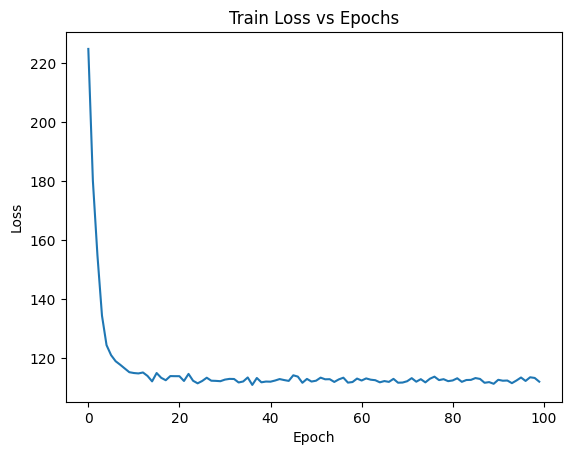

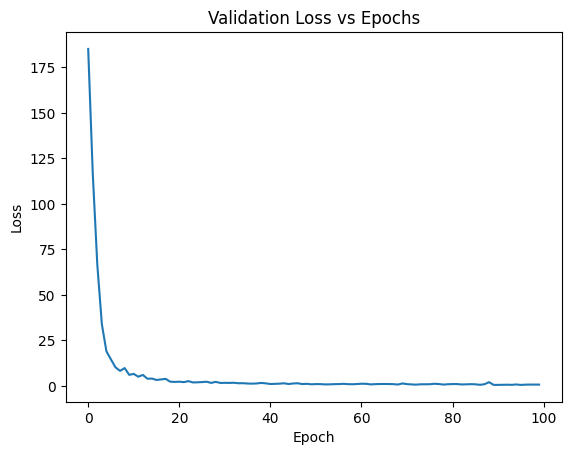

In [15]:
lr = 0.01
target_only_model = GTSRB_CNN(False).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(target_only_model.parameters(), lr = lr, momentum = 0.9)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train(target_trainloader, target_valloader, 
                                  target_testloader, target_only_model, optimizer, criterion, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_target_only.pt", scheduler)

In [16]:
model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_target_only.pt"
model.load_state_dict(torch.load(model_save_path))
model.eval()
evaluate(model, target_valloader, False)

Class Label Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00        63
           5       1.00      1.00      1.00        72
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        33
           8       1.00      1.00      1.00        32
           9       1.00      1.00      1.00        42
          10       1.00      1.00      1.00        78
          11       1.00      1.00      1.00        42
          12       1.00      1.00      1.00        70
          13       1.00      1.00      1.00        64
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00        11
        

### Visualize

In [73]:
def visualize2D(source_feats, target_feats):
    # Create a two dimensional t-SNE projection of the embeddings
    tsne = TSNE(2, verbose = 1)
    tsne_proj_source = tsne.fit_transform(source_feats)
    tsne_proj_target = tsne.fit_transform(target_feats)
    
    # Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap("tab20")
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.scatter(tsne_proj_source[:, 0], tsne_proj_source[:, 1], 
               c = np.array(cmap(0)), label = "Source", alpha = 0.5)
    
    ax.scatter(tsne_proj_target[:, 0], tsne_proj_target[:, 1], 
               c = np.array(cmap(10)), label = "Target", alpha = 0.5)

    ax.legend(fontsize = "large", markerscale = 2)
    plt.show()

In [36]:
def extract_feats(model, loader):
    model = model.to(device)
    all_feats = []
    
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        feats = model.feature(data).cpu().detach().numpy()
        all_feats.append(feats)

    all_feats = np.vstack(np.array(all_feats))
    return all_feats

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.003s...
[t-SNE] Computed neighbors for 1280 samples in 0.159s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 5.367984
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.194920
[t-SNE] KL divergence after 1000 iterations: 0.429916
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.002s...
[t-SNE] Computed neighbors for 1280 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 4.397686
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.338760
[t-SNE] KL divergence after 1000 iterations: 0.986293


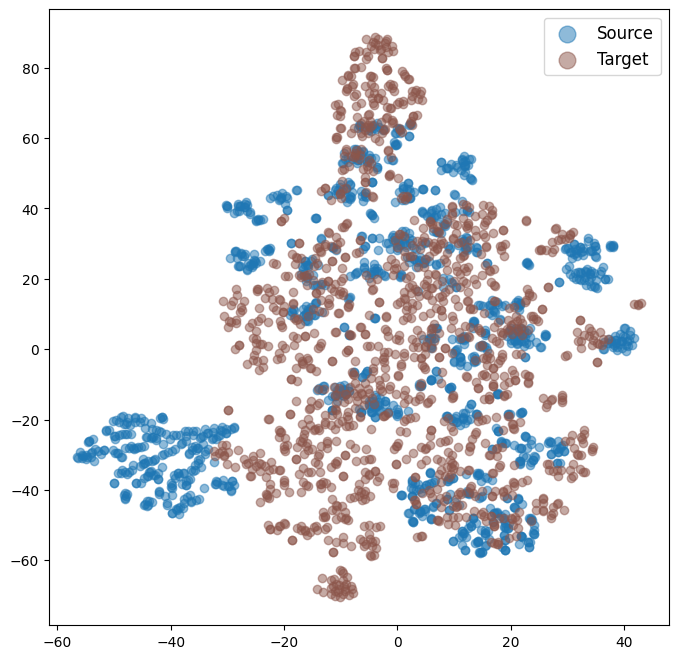

In [41]:
grl_model = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt"
grl_model.load_state_dict(torch.load(model_save_path))
grl_model.eval()

source_feats = extract_feats(grl_model, source_valloader)[:1280, :]
target_feats = extract_feats(grl_model, target_valloader)[:1280, :]
visualize2D(source_feats, target_feats)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.003s...
[t-SNE] Computed neighbors for 1280 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 20.535528
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.877777
[t-SNE] KL divergence after 1000 iterations: 0.391068
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.002s...
[t-SNE] Computed neighbors for 1280 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 3.236740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.968597
[t-SNE] KL divergence after 1000 iterations: 0.846327


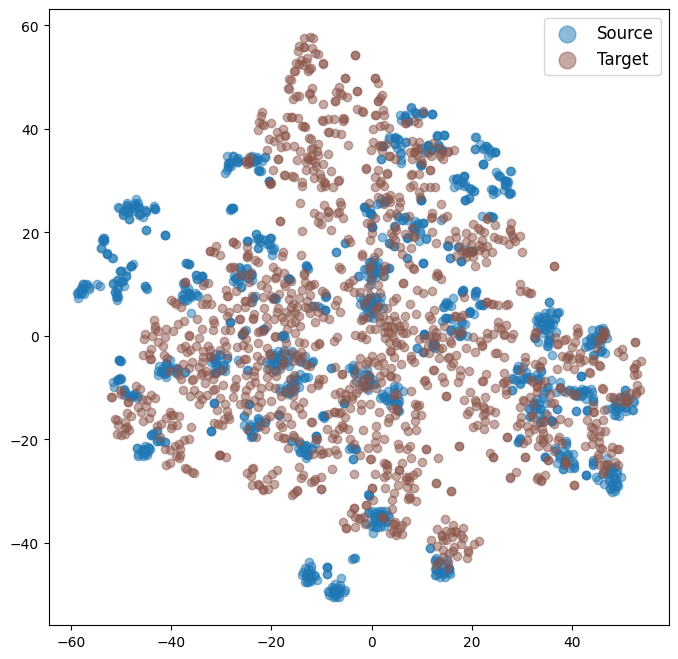

In [42]:
source_only_model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_source_only.pt"
source_only_model.load_state_dict(torch.load(model_save_path))
source_only_model.eval()

source_feats = extract_feats(source_only_model, source_valloader)[:1280, :]
target_feats = extract_feats(source_only_model, target_valloader)[:1280, :]
visualize2D(source_feats, target_feats)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.003s...
[t-SNE] Computed neighbors for 1280 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 21.312405
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.076385
[t-SNE] KL divergence after 1000 iterations: 0.530950
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.002s...
[t-SNE] Computed neighbors for 1280 samples in 0.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 11.896136
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.798012
[t-SNE] KL divergence after 1000 iterations: 0.766675


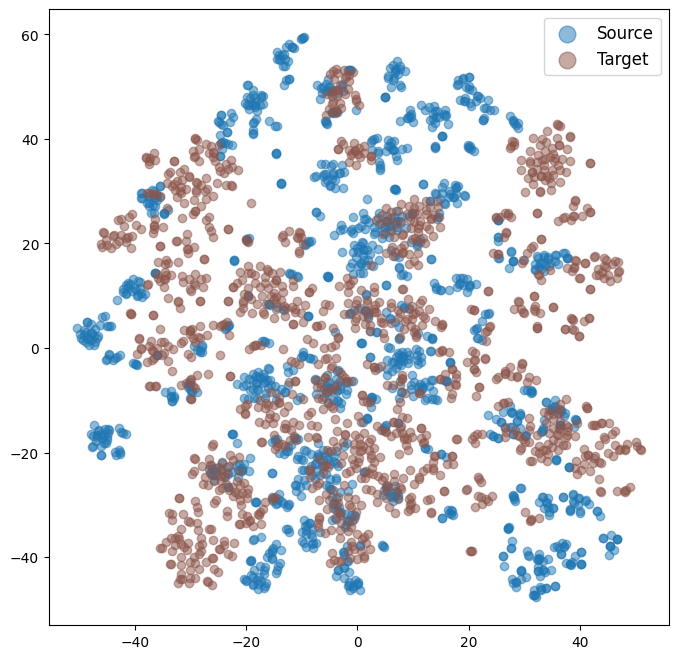

In [44]:
target_only_model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_target_only.pt"
target_only_model.load_state_dict(torch.load(model_save_path))
target_only_model.eval()

source_feats = extract_feats(target_only_model, source_valloader)[:1280, :]
target_feats = extract_feats(target_only_model, target_valloader)[:1280, :]
visualize2D(source_feats, target_feats)

In [70]:
def visualize3D(source_feats, target_feats):
    # Create a two dimensional t-SNE projection of the embeddings
    tsne = TSNE(3, verbose = 1)
    tsne_proj_source = tsne.fit_transform(source_feats)
    tsne_proj_target = tsne.fit_transform(target_feats)
    
    # Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap("tab20")
    # fig, ax = plt.subplots(figsize=(8, 8))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = "3d")
    
    ax.scatter(tsne_proj_source[:, 0], tsne_proj_source[:, 1], tsne_proj_source[:, 2],
               c = np.array(cmap(0)), label = "Source", alpha = 0.5)
    
    ax.scatter(tsne_proj_target[:, 0], tsne_proj_target[:, 1], tsne_proj_target[:, 2],
               c = np.array(cmap(10)), label = "Target", alpha = 0.5)

    ax.legend(fontsize = "large", markerscale = 2)
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.624628
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.237835
[t-SNE] KL divergence after 1000 iterations: 0.332969
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.478326
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.233398


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 0.802340


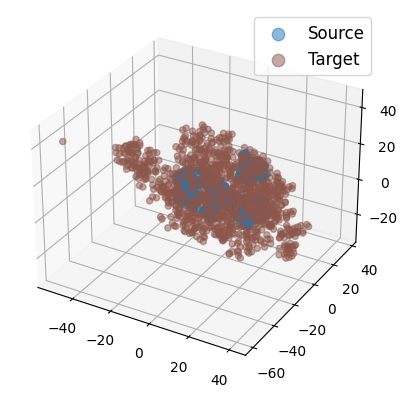

In [71]:
grl_model = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt"
grl_model.load_state_dict(torch.load(model_save_path))
grl_model.eval()

source_feats = extract_feats(grl_model, source_valloader)[:1000, :]
target_feats = extract_feats(grl_model, target_valloader)[:1000, :]
visualize3D(source_feats, target_feats)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.003s...
[t-SNE] Computed neighbors for 1280 samples in 0.174s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 20.592178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.383377
[t-SNE] KL divergence after 1000 iterations: 0.315390
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.002s...
[t-SNE] Computed neighbors for 1280 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 3.236740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.599731


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 0.688792


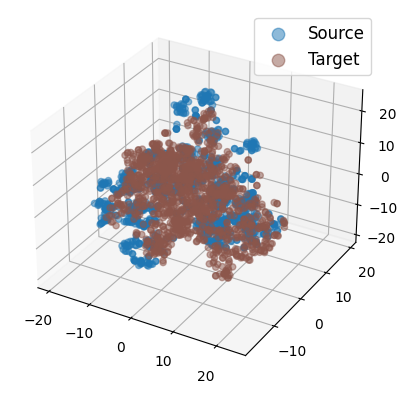

In [72]:
source_only_model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_source_only.pt"
source_only_model.load_state_dict(torch.load(model_save_path))
source_only_model.eval()

source_feats = extract_feats(source_only_model, source_valloader)[:1280, :]
target_feats = extract_feats(source_only_model, target_valloader)[:1280, :]
visualize3D(source_feats, target_feats)